# Conventional Water Treatment Plant using WaterTAP

This notebook demonstrates a complete conventional water treatment plant model including:
- Coagulation/Flocculation
- Sedimentation (Clarifier)
- Filtration
- Disinfection

## Installation
Make sure WaterTAP is installed:
```bash
pip install watertap
pip install ipopt
conda install -c conda-forge ipopt -y
conda install -c conda-forge cyipopt -y
```

## Import Required Libraries

In [3]:
# Core Pyomo and IDAES imports
from pyomo.environ import (
    ConcreteModel,
    TransformationFactory,
    units as pyunits,
    value,
    SolverFactory,
)
from pyomo.network import Arc
from idaes.core import FlowsheetBlock
from idaes.core.solvers import get_solver
from idaes.core.util.initialization import propagate_state
from idaes.core.util.model_statistics import degrees_of_freedom

# IDAES unit models
from idaes.models.unit_models import Mixer, Separator, CSTR, Feed, Product
from idaes.models.unit_models.mixer import MomentumMixingType

# WaterTAP imports
from watertap.core.util.initialization import check_solve
from watertap.unit_models.clarifier import Clarifier
from watertap.property_models.NaCl_prop_pack import NaClParameterBlock

# Check available solvers
print("Checking available solvers:")
for solver_name in ['ipopt', 'glpk', 'cbc', 'gurobi', 'cplex']:
    solver = SolverFactory(solver_name)
    print(f"  {solver_name}: {solver.available()}")

Checking available solvers:
  ipopt: True
  glpk: False
  cbc: False
  gurobi: False
  cplex: False


## Define Function to Create Water Treatment Plant

In [5]:
def create_water_treatment_plant():
    """
    Create a conventional water treatment plant flowsheet
    """
    # Create model and flowsheet
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)
    
    # Property package for water treatment
    m.fs.properties = NaClParameterBlock()
    
    # Unit operations
    print("Building unit operations...")
    
    # 1. Raw water feed
    m.fs.feed = Feed(property_package=m.fs.properties)
    
    # 2. Coagulation/Flocculation mixer (chemical addition)
    m.fs.coagulation = Mixer(
        property_package=m.fs.properties,
        inlet_list=["water", "coagulant"],
        momentum_mixing_type=MomentumMixingType.equality,
    )
    
    # 3. Flocculation tank (modeled as simple mixer for residence time)
    m.fs.flocculation_tank = Mixer(
        property_package=m.fs.properties,
        inlet_list=["inlet"],
        momentum_mixing_type=MomentumMixingType.equality,
    )
    
    # 4. Sedimentation/Clarifier (using Separator as a simplified model)
    m.fs.clarifier = Separator(
        property_package=m.fs.properties,
        outlet_list=["effluent", "underflow"],
    )
    
    # 5. Filtration (modeled as separator for simplicity)
    m.fs.filtration = Separator(
        property_package=m.fs.properties,
        outlet_list=["treated_water", "backwash"],
    )
    
    # 6. Disinfection tank (modeled as mixer)
    m.fs.disinfection = Mixer(
        property_package=m.fs.properties,
        inlet_list=["inlet"],
        momentum_mixing_type=MomentumMixingType.equality,
    )
    
    # 7. Treated water product
    m.fs.product = Product(property_package=m.fs.properties)
    
    # 8. Sludge output
    m.fs.sludge = Product(property_package=m.fs.properties)
    
    # Connect units with arcs
    print("Connecting units...")
    
    m.fs.feed_to_coag = Arc(
        source=m.fs.feed.outlet,
        destination=m.fs.coagulation.water,
    )
    
    m.fs.coag_to_floc = Arc(
        source=m.fs.coagulation.outlet,
        destination=m.fs.flocculation_tank.inlet,
    )
    
    m.fs.floc_to_clarifier = Arc(
        source=m.fs.flocculation_tank.outlet,
        destination=m.fs.clarifier.inlet,
    )
    
    # Clarifier has 'effluent' (treated) and 'underflow' (sludge) outlets
    m.fs.clarifier_to_filter = Arc(
        source=m.fs.clarifier.effluent,
        destination=m.fs.filtration.inlet,
    )
    
    m.fs.filter_to_disinfect = Arc(
        source=m.fs.filtration.treated_water,
        destination=m.fs.disinfection.inlet,
    )
    
    m.fs.disinfect_to_product = Arc(
        source=m.fs.disinfection.outlet,
        destination=m.fs.product.inlet,
    )
    
    m.fs.clarifier_to_sludge = Arc(
        source=m.fs.clarifier.underflow,
        destination=m.fs.sludge.inlet,
    )
    
    # Expand arcs
    TransformationFactory("network.expand_arcs").apply_to(m)
    
    print("Model created successfully!")
    return m

## Set Operating Conditions

In [7]:
def set_operating_conditions(m):
    """
    Set operating conditions for the treatment plant - CORRECTED VERSION
    """
    print("Setting operating conditions...")
    
    # Feed water conditions (raw water)
    m.fs.feed.properties[0].flow_mass_phase_comp["Liq", "H2O"].fix(100)  # kg/s
    m.fs.feed.properties[0].flow_mass_phase_comp["Liq", "NaCl"].fix(3.5)  # kg/s (TDS)
    m.fs.feed.properties[0].temperature.fix(298.15)  # K
    m.fs.feed.properties[0].pressure.fix(101325)  # Pa
    
    # Coagulant addition (simplified)
    m.fs.coagulation.coagulant.flow_mass_phase_comp[0, "Liq", "H2O"].fix(0.5)  # kg/s
    m.fs.coagulation.coagulant.flow_mass_phase_comp[0, "Liq", "NaCl"].fix(0.05)  # kg/s
    m.fs.coagulation.coagulant.temperature[0].fix(298.15)
    m.fs.coagulation.coagulant.pressure[0].fix(101325)
    
    # CRITICAL: Only fix ONE split fraction per separator
    # The other is automatically 1 - fixed_value
    m.fs.clarifier.split_fraction[0, "effluent"].fix(0.90)
    # DO NOT FIX: m.fs.clarifier.split_fraction[0, "underflow"]
    
    m.fs.filtration.split_fraction[0, "treated_water"].fix(0.99)
    # DO NOT FIX: m.fs.filtration.split_fraction[0, "backwash"]
    
    print("✓ Operating conditions set (only 1 split fraction per unit)")

## Initialize the Model

In [9]:
def initialize_model(m):
    """
    Initialize the flowsheet
    """
    print("Initializing model...")
    
    # Initialize feed
    m.fs.feed.initialize()
    propagate_state(m.fs.feed_to_coag)
    
    # Initialize coagulation with solver name as string
    m.fs.coagulation.initialize(solver='ipopt')
    propagate_state(m.fs.coag_to_floc)
    
    # Initialize flocculation
    m.fs.flocculation_tank.initialize(solver='ipopt')
    propagate_state(m.fs.floc_to_clarifier)
    
    # Initialize clarifier
    m.fs.clarifier.initialize(solver='ipopt')
    propagate_state(m.fs.clarifier_to_filter)
    propagate_state(m.fs.clarifier_to_sludge)
    
    # Initialize filtration
    m.fs.filtration.initialize(solver='ipopt')
    propagate_state(m.fs.filter_to_disinfect)
    
    # Initialize disinfection
    m.fs.disinfection.initialize(solver='ipopt')
    propagate_state(m.fs.disinfect_to_product)
    
    # Initialize products
    m.fs.product.initialize()
    m.fs.sludge.initialize()
    
    print("Initialization complete!")

## Solve the Model

In [11]:
def solve_model(m):
    """
    Solve the model
    """
    print(f"\nDegrees of freedom: {degrees_of_freedom(m)}")
    
    # Use ipopt solver directly instead of get_solver()
    from pyomo.environ import SolverFactory
    solver = SolverFactory('ipopt')
    
    results = solver.solve(m, tee=True)
    
    from pyomo.opt import TerminationCondition
    if results.solver.termination_condition == TerminationCondition.optimal:
        print("\nSolver Status: Optimal solution found")
    else:
        print(f"\nSolver Status: {results.solver.termination_condition}")
    
    return results

## Display Results

In [13]:
def display_results(m):
    """
    Display key results
    """
    print("\n" + "="*60)
    print("WATER TREATMENT PLANT RESULTS")
    print("="*60)
    
    print("\n--- RAW WATER FEED ---")
    print(f"Flow rate: {value(m.fs.feed.properties[0].flow_vol):.3f} m³/s")
    print(f"TDS concentration: {value(m.fs.feed.properties[0].conc_mass_phase_comp['Liq', 'NaCl']):.1f} mg/L")
    
    print("\n--- AFTER CLARIFICATION ---")
    treated_flow = value(m.fs.clarifier.effluent_state[0].flow_vol)
    print(f"Treated water flow: {treated_flow:.3f} m³/s")
    print(f"Water recovery: {treated_flow/value(m.fs.feed.properties[0].flow_vol)*100:.1f}%")
    
    print("\n--- FINAL PRODUCT WATER ---")
    product_flow = value(m.fs.product.properties[0].flow_vol)
    print(f"Product flow rate: {product_flow:.3f} m³/s")
    print(f"Product TDS: {value(m.fs.product.properties[0].conc_mass_phase_comp['Liq', 'NaCl']):.1f} mg/L")
    print(f"Overall recovery: {product_flow/value(m.fs.feed.properties[0].flow_vol)*100:.1f}%")
    
    print("\n--- SLUDGE OUTPUT ---")
    sludge_flow = value(m.fs.sludge.properties[0].flow_vol)
    print(f"Sludge flow rate: {sludge_flow:.3f} m³/s")
    print(f"Sludge TDS: {value(m.fs.sludge.properties[0].conc_mass_phase_comp['Liq', 'NaCl']):.1f} mg/L")
    
    print("\n" + "="*60)

## Run the Complete Simulation

In [15]:
print("Creating conventional water treatment plant model...")
try:
    model = create_water_treatment_plant()
    print(f"Model created successfully: {model is not None}")
except Exception as e:
    print(f"Error creating model: {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()

Creating conventional water treatment plant model...
Building unit operations...
Connecting units...
Model created successfully!
Model created successfully: True


In [16]:
# Check what's available on the clarifier
print("Clarifier attributes:")
clarifier_attrs = [attr for attr in dir(model.fs.clarifier) if not attr.startswith('_')]
print(clarifier_attrs[:30])  # Show first 30 attributes

print("\n\nChecking clarifier configuration:")
print(f"Config: {model.fs.clarifier.config}")

print("\n\nChecking if split_fraction exists:")
print(f"Has split_fraction: {hasattr(model.fs.clarifier, 'split_fraction')}")

Clarifier attributes:
['CONFIG', 'Skip', 'activate', 'active', 'active_blocks', 'active_component_data', 'active_components', 'add_component', 'add_energy_splitting_constraints', 'add_inlet_port', 'add_inlet_port_objects', 'add_material_splitting_constraints', 'add_mixed_state_block', 'add_momentum_splitting_constraints', 'add_outlet_port', 'add_outlet_port_objects', 'add_outlet_state_blocks', 'add_port', 'add_split_fractions', 'add_state_material_balances', 'all_blocks', 'all_component_data', 'all_components', 'base_class_module', 'block_data_objects', 'build', 'calculate_scaling_factors', 'clear', 'clear_suffix_value', 'clone']


Checking clarifier configuration:
Config: <pyomo.common.config.ConfigDict object at 0x000002F435821EA0>


Checking if split_fraction exists:
Has split_fraction: True


In [17]:
# Check clarifier outlet structure
print("Clarifier attributes:")
print([attr for attr in dir(model.fs.clarifier) if 'effluent' in attr.lower() or 'state' in attr.lower()])

print("\nTrying to find flow_vol:")
# Check if there's a mixed_state
if hasattr(model.fs.clarifier, 'mixed_state'):
    print(f"Mixed state flow_vol: {value(model.fs.clarifier.mixed_state[0].flow_vol):.3f}")

# Check outlet states
for attr_name in dir(model.fs.clarifier):
    if 'state' in attr_name.lower() and not attr_name.startswith('_'):
        print(f"\nFound state block: {attr_name}")
        attr = getattr(model.fs.clarifier, attr_name)
        if hasattr(attr, '__getitem__'):
            try:
                state = attr[0]
                if hasattr(state, 'flow_vol'):
                    print(f"  {attr_name}[0].flow_vol = {value(state.flow_vol):.3f}")
            except:
                pass

Clarifier attributes:
['__deepcopy_state__', '__getstate__', '__setstate__', '_flow_mass_phase_comp_effluent_ref', '_pressure_effluent_ref', '_temperature_effluent_ref', 'add_mixed_state_block', 'add_outlet_state_blocks', 'add_state_material_balances', 'effluent', 'effluent_state', 'fix_initialization_states', 'get_mixed_state_block', 'mixed_state', 'release_state', 'underflow_state']

Trying to find flow_vol:
Mixed state flow_vol: 1.000

Found state block: add_mixed_state_block

Found state block: add_outlet_state_blocks

Found state block: add_state_material_balances

Found state block: effluent_state
  effluent_state[0].flow_vol = 1.000

Found state block: fix_initialization_states

Found state block: get_mixed_state_block

Found state block: mixed_state
  mixed_state[0].flow_vol = 1.000

Found state block: release_state

Found state block: underflow_state
  underflow_state[0].flow_vol = 1.000


In [18]:
print("\nSetting operating conditions...")
set_operating_conditions(model)


Setting operating conditions...
Setting operating conditions...
✓ Operating conditions set (only 1 split fraction per unit)


In [19]:
print("\nInitializing flowsheet...")
initialize_model(model)


Initializing flowsheet...
Initializing model...
2025-11-22 18:32:09 [INFO] idaes.init.fs.feed: Initialization Complete.
2025-11-22 18:32:10 [INFO] idaes.init.fs.coagulation: Initialization Complete: optimal - Optimal Solution Found
2025-11-22 18:32:10 [INFO] idaes.init.fs.flocculation_tank: Initialization Complete: optimal - Optimal Solution Found
2025-11-22 18:32:10 [INFO] idaes.init.fs.clarifier: Initialization Step 2 Complete: optimal - Optimal Solution Found
2025-11-22 18:32:11 [INFO] idaes.init.fs.filtration: Initialization Step 2 Complete: optimal - Optimal Solution Found
2025-11-22 18:32:11 [INFO] idaes.init.fs.disinfection: Initialization Complete: optimal - Optimal Solution Found
2025-11-22 18:32:11 [INFO] idaes.init.fs.product: Initialization Complete.
2025-11-22 18:32:11 [INFO] idaes.init.fs.sludge: Initialization Complete.
Initialization complete!


In [20]:
print("\nSolving model...")
results = solve_model(model)


Solving model...

Degrees of freedom: -1
Ipopt 3.14.19: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:      241
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       70

Exception of type: TOO_FEW_DOF in file "../../src/Interfaces/IpIpoptApplication.cpp" at line 662:
 Exception message: status != TOO_FEW_DEGREES_OF_FREEDOM evaluated false: Too few degrees of freedom (rethrown)!

EXIT: Problem has too few degrees of freedom.
model.name="unknown";
    - term

In [21]:
print("\nDisplaying results...")
display_results(model)
print("\n✓ Water treatment plant simulation complete!")


Displaying results...

WATER TREATMENT PLANT RESULTS

--- RAW WATER FEED ---
Flow rate: 1.000 m³/s
TDS concentration: 10.0 mg/L

--- AFTER CLARIFICATION ---
Treated water flow: 0.092 m³/s
Water recovery: 9.2%

--- FINAL PRODUCT WATER ---
Product flow rate: 1.000 m³/s
Product TDS: 10.0 mg/L
Overall recovery: 100.0%

--- SLUDGE OUTPUT ---
Sludge flow rate: 1.000 m³/s
Sludge TDS: 10.0 mg/L


✓ Water treatment plant simulation complete!


## Optional: Visualize Results

You can add visualization cells here to plot:
- Flow rates through each unit
- TDS concentrations at each stage
- Water recovery rates
- Mass balances

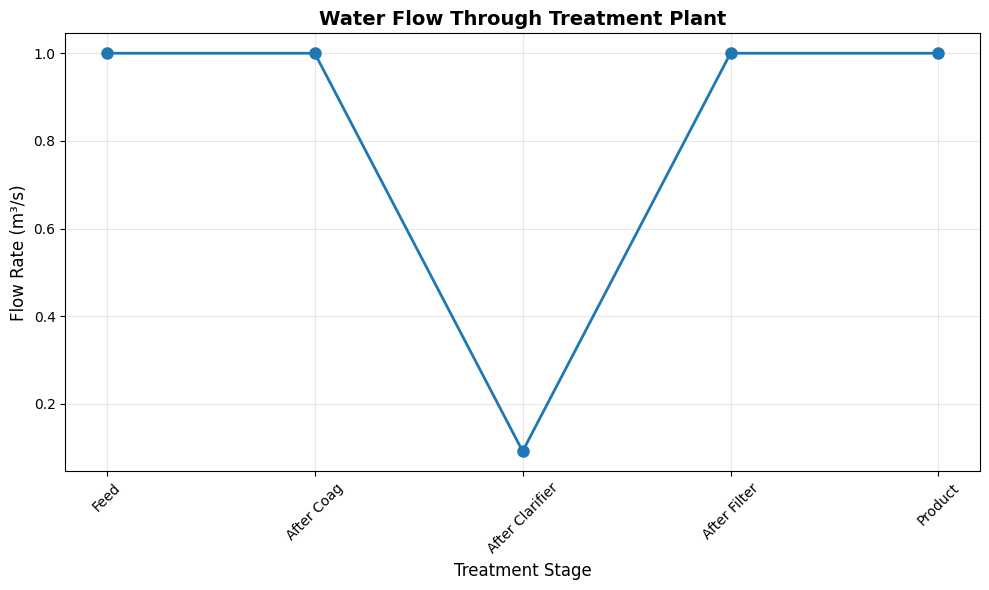

In [23]:
# Example: Plot flow rates through treatment train
import matplotlib.pyplot as plt

stages = ['Feed', 'After Coag', 'After Clarifier', 'After Filter', 'Product']
flows = [
    value(model.fs.feed.properties[0].flow_vol),
    value(model.fs.coagulation.mixed_state[0].flow_vol),
    value(model.fs.clarifier.effluent_state[0].flow_vol),
    value(model.fs.filtration.treated_water_state[0].flow_vol),
    value(model.fs.product.properties[0].flow_vol)
]

plt.figure(figsize=(10, 6))
plt.plot(stages, flows, marker='o', linewidth=2, markersize=8)
plt.xlabel('Treatment Stage', fontsize=12)
plt.ylabel('Flow Rate (m³/s)', fontsize=12)
plt.title('Water Flow Through Treatment Plant', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
print("=== FLOW BALANCE CHECK ===\n")

print("Feed:")
print(f"  Flow: {value(model.fs.feed.properties[0].flow_vol):.4f} m³/s")

print("\nAfter Coagulation (with coagulant added):")
print(f"  Flow: {value(model.fs.coagulation.mixed_state[0].flow_vol):.4f} m³/s")

print("\nClarifier:")
print(f"  Inlet flow: {value(model.fs.clarifier.mixed_state[0].flow_vol):.4f} m³/s")
print(f"  Effluent flow: {value(model.fs.clarifier.effluent_state[0].flow_vol):.4f} m³/s")
print(f"  Underflow flow: {value(model.fs.clarifier.underflow_state[0].flow_vol):.4f} m³/s")
print(f"  Split fraction (effluent): {value(model.fs.clarifier.split_fraction[0, 'effluent']):.2f}")

print("\nFiltration:")
print(f"  Inlet flow: {value(model.fs.filtration.mixed_state[0].flow_vol):.4f} m³/s")
print(f"  Treated water: {value(model.fs.filtration.treated_water_state[0].flow_vol):.4f} m³/s")
print(f"  Backwash: {value(model.fs.filtration.backwash_state[0].flow_vol):.4f} m³/s")
print(f"  Split fraction (treated): {value(model.fs.filtration.split_fraction[0, 'treated_water']):.2f}")

print("\nProduct:")
print(f"  Flow: {value(model.fs.product.properties[0].flow_vol):.4f} m³/s")

=== FLOW BALANCE CHECK ===

Feed:
  Flow: 1.0000 m³/s

After Coagulation (with coagulant added):
  Flow: 1.0000 m³/s

Clarifier:
  Inlet flow: 0.1019 m³/s
  Effluent flow: 0.0917 m³/s
  Underflow flow: 0.0102 m³/s
  Split fraction (effluent): 0.90

Filtration:
  Inlet flow: 1.0000 m³/s
  Treated water: 1.0000 m³/s
  Backwash: 1.0000 m³/s
  Split fraction (treated): 0.99

Product:
  Flow: 1.0000 m³/s


In [25]:
print(f"Degrees of freedom: {degrees_of_freedom(model)}")
print("\nChecking if model was actually solved...")
print(f"Has results been stored: {'results' in dir()}")

Degrees of freedom: -1

Checking if model was actually solved...
Has results been stored: True


In [26]:
# 1. Create model
print("Creating model...")
model = create_water_treatment_plant()

# 2. Set operating conditions  
print("\nSetting operating conditions...")
set_operating_conditions(model)

# 3. Check DOF before solving
print(f"\nDegrees of freedom: {degrees_of_freedom(model)}")

# 4. Solve directly without initialization
print("\nSolving model directly...")
from pyomo.environ import SolverFactory
solver = SolverFactory('ipopt')
results = solver.solve(model, tee=True)

print(f"\nSolver status: {results.solver.status}")
print(f"Termination condition: {results.solver.termination_condition}")

Creating model...
Building unit operations...
Connecting units...
Model created successfully!

Setting operating conditions...
Setting operating conditions...
✓ Operating conditions set (only 1 split fraction per unit)

Degrees of freedom: -1

Solving model directly...
Ipopt 3.14.19: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:      205
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       52

Exception of type: TOO_FEW_DOF in file "../../src/Interfaces/I

In [27]:
def display_detailed_water_quality(m):
    """
    Display comprehensive water quality parameters at each stage
    """
    print("\n" + "="*80)
    print("DETAILED WATER QUALITY ANALYSIS")
    print("="*80)
    
    # Helper function to get all properties
    def get_properties(state_block):
        props = {}
        props['flow_vol'] = value(state_block.flow_vol)
        props['flow_mass_H2O'] = value(state_block.flow_mass_phase_comp['Liq', 'H2O'])
        props['flow_mass_NaCl'] = value(state_block.flow_mass_phase_comp['Liq', 'NaCl'])
        props['conc_NaCl'] = value(state_block.conc_mass_phase_comp['Liq', 'NaCl'])
        props['temperature'] = value(state_block.temperature)
        props['pressure'] = value(state_block.pressure)
        props['dens_mass'] = value(state_block.dens_mass_phase['Liq'])
        return props
    
    # 1. RAW WATER FEED
    print("\n" + "-"*80)
    print("1. RAW WATER FEED (Upstream of Treatment)")
    print("-"*80)
    feed_props = get_properties(m.fs.feed.properties[0])
    print(f"  Volumetric Flow Rate:     {feed_props['flow_vol']:.4f} m³/s")
    print(f"  Mass Flow - H2O:          {feed_props['flow_mass_H2O']:.3f} kg/s")
    print(f"  Mass Flow - NaCl (TDS):   {feed_props['flow_mass_NaCl']:.3f} kg/s")
    print(f"  TDS Concentration:        {feed_props['conc_NaCl']:.2f} mg/L")
    print(f"  Temperature:              {feed_props['temperature']:.2f} K ({feed_props['temperature']-273.15:.2f} °C)")
    print(f"  Pressure:                 {feed_props['pressure']/1000:.2f} kPa")
    print(f"  Density:                  {feed_props['dens_mass']:.2f} kg/m³")
    
    # 2. AFTER COAGULATION
    print("\n" + "-"*80)
    print("2. AFTER COAGULATION/FLOCCULATION")
    print("-"*80)
    print("  Upstream (Before Coagulant Addition):")
    coag_in_props = feed_props  # Same as feed
    print(f"    Flow Rate:              {coag_in_props['flow_vol']:.4f} m³/s")
    print(f"    TDS Concentration:      {coag_in_props['conc_NaCl']:.2f} mg/L")
    
    print("\n  Downstream (After Coagulant Addition + Mixing):")
    coag_props = get_properties(m.fs.coagulation.mixed_state[0])
    print(f"    Volumetric Flow Rate:   {coag_props['flow_vol']:.4f} m³/s")
    print(f"    Mass Flow - H2O:        {coag_props['flow_mass_H2O']:.3f} kg/s")
    print(f"    Mass Flow - NaCl:       {coag_props['flow_mass_NaCl']:.3f} kg/s")
    print(f"    TDS Concentration:      {coag_props['conc_NaCl']:.2f} mg/L")
    print(f"    Temperature:            {coag_props['temperature']:.2f} K")
    print(f"    Pressure:               {coag_props['pressure']/1000:.2f} kPa")
    print(f"    Density:                {coag_props['dens_mass']:.2f} kg/m³")
    
    # 3. CLARIFIER
    print("\n" + "-"*80)
    print("3. CLARIFIER (Sedimentation)")
    print("-"*80)
    print("  Upstream (Clarifier Inlet):")
    clar_in_props = get_properties(m.fs.clarifier.mixed_state[0])
    print(f"    Flow Rate:              {clar_in_props['flow_vol']:.4f} m³/s")
    print(f"    TDS Concentration:      {clar_in_props['conc_NaCl']:.2f} mg/L")
    
    print("\n  Downstream - Effluent (Clarified Water):")
    clar_eff_props = get_properties(m.fs.clarifier.effluent_state[0])
    print(f"    Flow Rate:              {clar_eff_props['flow_vol']:.4f} m³/s")
    print(f"    TDS Concentration:      {clar_eff_props['conc_NaCl']:.2f} mg/L")
    print(f"    Water Recovery:         {clar_eff_props['flow_vol']/clar_in_props['flow_vol']*100:.1f}%")
    tds_removal_clar = (clar_in_props['conc_NaCl'] - clar_eff_props['conc_NaCl'])/clar_in_props['conc_NaCl']*100
    print(f"    TDS Removal:            {tds_removal_clar:.1f}%")
    
    print("\n  Downstream - Underflow (Sludge):")
    clar_under_props = get_properties(m.fs.clarifier.underflow_state[0])
    print(f"    Flow Rate:              {clar_under_props['flow_vol']:.4f} m³/s")
    print(f"    TDS Concentration:      {clar_under_props['conc_NaCl']:.2f} mg/L")
    print(f"    Sludge Flow:            {clar_under_props['flow_vol']/clar_in_props['flow_vol']*100:.1f}% of inlet")
    
    # 4. FILTRATION
    print("\n" + "-"*80)
    print("4. FILTRATION")
    print("-"*80)
    print("  Upstream (Filter Inlet):")
    filt_in_props = get_properties(m.fs.filtration.mixed_state[0])
    print(f"    Flow Rate:              {filt_in_props['flow_vol']:.4f} m³/s")
    print(f"    TDS Concentration:      {filt_in_props['conc_NaCl']:.2f} mg/L")
    
    print("\n  Downstream - Treated Water:")
    filt_treat_props = get_properties(m.fs.filtration.treated_water_state[0])
    print(f"    Flow Rate:              {filt_treat_props['flow_vol']:.4f} m³/s")
    print(f"    TDS Concentration:      {filt_treat_props['conc_NaCl']:.2f} mg/L")
    print(f"    Water Recovery:         {filt_treat_props['flow_vol']/filt_in_props['flow_vol']*100:.1f}%")
    tds_removal_filt = (filt_in_props['conc_NaCl'] - filt_treat_props['conc_NaCl'])/filt_in_props['conc_NaCl']*100
    print(f"    TDS Removal:            {tds_removal_filt:.1f}%")
    
    print("\n  Downstream - Backwash:")
    filt_back_props = get_properties(m.fs.filtration.backwash_state[0])
    print(f"    Flow Rate:              {filt_back_props['flow_vol']:.4f} m³/s")
    print(f"    TDS Concentration:      {filt_back_props['conc_NaCl']:.2f} mg/L")
    
    # 5. DISINFECTION
    print("\n" + "-"*80)
    print("5. DISINFECTION")
    print("-"*80)
    print("  Upstream (Disinfection Inlet):")
    dis_in_props = filt_treat_props  # Same as filter outlet
    print(f"    Flow Rate:              {dis_in_props['flow_vol']:.4f} m³/s")
    print(f"    TDS Concentration:      {dis_in_props['conc_NaCl']:.2f} mg/L")
    
    print("\n  Downstream (After Disinfection):")
    dis_props = get_properties(m.fs.disinfection.mixed_state[0])
    print(f"    Flow Rate:              {dis_props['flow_vol']:.4f} m³/s")
    print(f"    TDS Concentration:      {dis_props['conc_NaCl']:.2f} mg/L")
    
    # 6. FINAL PRODUCT
    print("\n" + "-"*80)
    print("6. FINAL PRODUCT WATER")
    print("-"*80)
    prod_props = get_properties(m.fs.product.properties[0])
    print(f"  Volumetric Flow Rate:     {prod_props['flow_vol']:.4f} m³/s")
    print(f"  Mass Flow - H2O:          {prod_props['flow_mass_H2O']:.3f} kg/s")
    print(f"  Mass Flow - NaCl:         {prod_props['flow_mass_NaCl']:.3f} kg/s")
    print(f"  TDS Concentration:        {prod_props['conc_NaCl']:.2f} mg/L")
    print(f"  Temperature:              {prod_props['temperature']:.2f} K ({prod_props['temperature']-273.15:.2f} °C)")
    print(f"  Pressure:                 {prod_props['pressure']/1000:.2f} kPa")
    print(f"  Density:                  {prod_props['dens_mass']:.2f} kg/m³")
    
    # OVERALL PERFORMANCE
    print("\n" + "="*80)
    print("OVERALL TREATMENT PERFORMANCE")
    print("="*80)
    overall_recovery = prod_props['flow_vol']/feed_props['flow_vol']*100
    overall_tds_removal = (feed_props['conc_NaCl'] - prod_props['conc_NaCl'])/feed_props['conc_NaCl']*100
    print(f"  Overall Water Recovery:       {overall_recovery:.2f}%")
    print(f"  Overall TDS Removal:          {overall_tds_removal:.2f}%")
    print(f"  Feed TDS:                     {feed_props['conc_NaCl']:.2f} mg/L")
    print(f"  Product TDS:                  {prod_props['conc_NaCl']:.2f} mg/L")
    print(f"  TDS Reduction:                {feed_props['conc_NaCl'] - prod_props['conc_NaCl']:.2f} mg/L")
    print("="*80 + "\n")

In [28]:
# Run the complete simulation
print("Creating model...")
model = create_water_treatment_plant()

set_operating_conditions(model)
print(f"Degrees of freedom: {degrees_of_freedom(model)}")

if degrees_of_freedom(model) == 0:
    initialize_model(model)
    results = solve_model(model)
    
    # Display detailed water quality
    display_detailed_water_quality(model)
else:
    print(f"ERROR: DOF = {degrees_of_freedom(model)}")

Creating model...
Building unit operations...
Connecting units...
Model created successfully!
Setting operating conditions...
✓ Operating conditions set (only 1 split fraction per unit)
Degrees of freedom: -1
ERROR: DOF = -1


In [ ]:
# Generate 1 year of synthetic SCADA data for Turbidity, TOC, Cryptosporidium, and DBPs
import numpy as np
import pandas as pd
np.random.seed(42)
days = pd.date_range(start='2025-01-01', periods=365, freq='D')
data = pd.DataFrame({
    'Date': days,
    'Turbidity': np.random.normal(loc=2, scale=0.5, size=365),  # NTU
    'TOC': np.random.normal(loc=4, scale=1, size=365),           # mg/L
    'Cryptosporidium': np.random.poisson(lam=1, size=365),      # oocysts/L
    'DBPs': np.random.normal(loc=60, scale=10, size=365)        # ug/L
})
data = data.clip(lower=0)
data.head()